# Aerodynamic Splatting

In [1]:
import numpy as np
from sympy import symbols, diff, Quaternion, exp, Matrix, lambdify, sin, cos, simplify, latex
#from sympy.physics.mechanics import *
import random
from IPython.display import display
import matplotlib.pyplot as plt
from aerosplat import *

## Symbolic Math

## Equation for quaternion
We provide two options for obtaining the quaternon.
In the case where a `numpy` array with four quaternion components are provided, we will obtain using the standard syntax `Quaternion(qw, qx, qy, qz)`.
In the case where a single component is provided, we will assume that this is a planar model with an angle evaluated about the $z$-axis, and obtain with the `Quaternion.from_axis_angle` class method.
We also will create the `idx_dimension` variable which shrinks subsequent matrices and vectors to use only the first two ($x$ and $y$) components.

In [2]:
display(quaternion_2d)

cos(θ/2) + 0*i + 0*j + sin(θ/2)*k

In [3]:
display(quaternion_3d)

q_w + q_x*i + q_y*j + q_z*k

## Equation for gaussian

The Gaussian equation that is created below uses the variance term _not-squared_, while in the plot I square this term.
There is reason for this; the variance that I will use below is going to be of the form

$\texttt{variance} = \sum_{i=1}^3 \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2$

where $x_i$ is a position coordinate for where we are measuring, $\bar{x}_i$ is the position coordinate for the center of the Gaussian, and $s_i$ is a scale coefficient representing one standard deviation in the direction of that coordinate.
Traditionally, we would evaluate the Gaussian at some count of standard deviations, which would derive from the square-root of the above expression.
To avoid taking a square-root, just to subsequently square the term again, we create the Gaussian as a function of the variance directly.
However, the plot below shows an evaluation of the Gaussian with respect to standard deviations.

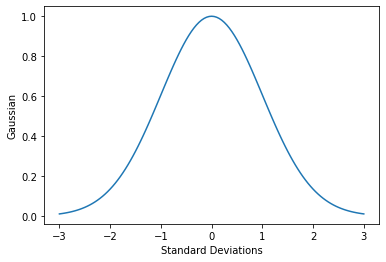

In [4]:
stdev = np.linspace(-3, 3, 121);
plt.plot(stdev, np.exp(-0.5 * stdev**2));
plt.xlabel("Standard Deviations");
plt.ylabel("Gaussian");

Here we create a function that obtains the rotation matrix from the quaternion, along with some simplification steps.
First, we substitute a value of 1 for the quaternion norm, as we will ensure that it is always a proper unit quaternion.
Second, we call the standard `simplify()` function.

In [5]:
display(rotation_eqn_2d)

Matrix([
[cos(θ), -sin(θ)],
[sin(θ),  cos(θ)]])

In [6]:
display(rotation_eqn_3d)
print(latex(rotation_eqn_2d))

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,   -2*q_w*q_z + 2*q_x*q_y,    2*q_w*q_y + 2*q_x*q_z],
[   2*q_w*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,   -2*q_w*q_x + 2*q_y*q_z],
[  -2*q_w*q_y + 2*q_x*q_z,    2*q_w*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

\left[\begin{matrix}\cos{\left(θ \right)} & - \sin{\left(θ \right)}\\\sin{\left(θ \right)} & \cos{\left(θ \right)}\end{matrix}\right]


In [7]:
display(Matrix(velocity_eqn_2d))

Matrix([
[u*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[v*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

We see the variance contained in the exponent

In [8]:
display(variance_eqn_2d)

s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 + s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2

### Velocity gradient equations

In [9]:
display(Matrix(variance_gradient_eqn_2d))

Matrix([
[ 2*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) + 2*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ)],
[-2*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) + 2*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ)]])

In [10]:
display(Matrix(velocity_gradient_eqn_2d))

Matrix([
[u*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[ v*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

In [11]:
display(Matrix(velocity_gradient_matrix_eqn_2d))

Matrix([
[u*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2), v*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[ u*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2),  v*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

## Splatting Class

In [12]:
a = AeroSplat(
    position=[0, 0], 
    velocity=[1, 0],
    scale=[1, 1],
    orientation=[0]
)
display(a)
display(a.quaternion)
display(a.rotation_matrix)
rk = np.array([2, 0])
display(a.velocity_at(rk))
display(a.differential_velocity_at(rk))
display(a.velocity_gradient_at(rk))
display(a.velocity_gradient_matrix_at(rk))

AeroSplat(position=[0 0], velocity=[1 0], scale=[1 1], orientation=[0])

1 + 0*i + 0*j + 0*k

array([[ 1., -0.],
       [ 0.,  1.]])

array([0.13533528, 0.        ])

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [-0.54134113, -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ]])

array([-0.27067057, -0.        ])

array([[-0.27067057, -0.        ],
       [ 0.        ,  0.        ]])

## Boundary Condition Class

In [13]:
source_boundary = LineBoundary(point0=[0, -1], point1=[0, 1], velocity=[10, 0])
plate_boundary = LineBoundary(point0=[1, -0.1], point1=[1, 0.1], velocity=[0, 0])
print(source_boundary)
print(source_boundary.point_at_random())

LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0])
[ 0.         -0.60169902]


## Problem Definition Class

In [14]:
problem = AeroSplatProblem(
    domain_x=[0, 2], 
    domain_y=[-1, 1],
    boundaries=[source_boundary, plate_boundary],
    spawn=4
)
print(problem)

AeroSplatProblem(
  domain_x=[0 2]
  domain_y=[-1  1]
  boundaries=[LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0]), LineBoundary(point0=[ 1.  -0.1], point1=[1.  0.1], velocity=[0 0])]
)


In [15]:
print(problem.velocity_on_grid(2, 2))
print(problem.euler_equation_terms_at(np.array([0, 0])))
print(problem.ndims)
print(problem.splats)

[[[-7.81969575e-04 -3.23514059e-04]
  [ 3.22832677e-03 -9.33387660e-03]]

 [[-6.69831391e-01 -9.01680290e-01]
  [-6.00852249e-03 -2.48402865e-03]]]
[ 0.46422638  0.19227263 -1.52465606]
2
[AeroSplat(position=[ 1.8107631  -0.17736793], velocity=[-0.6734744   0.60655541], scale=[7.66082041 9.65032808], orientation=[-0.03134082]), AeroSplat(position=[ 1.26715145 -0.91042468], velocity=[ 0.56655832 -0.71867594], scale=[1.55368056 4.50713672], orientation=[-1.93017693]), AeroSplat(position=[0.73794919 0.3533923 ], velocity=[-2.08105166 -0.86034314], scale=[2.57791456 1.89221006], orientation=[-1.02068986]), AeroSplat(position=[0.03402198 0.85304003], velocity=[-0.54913948 -1.32006362], scale=[8.15831834 2.87777899], orientation=[-1.22072096])]


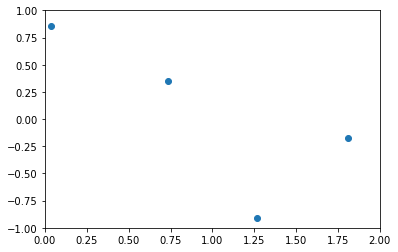

In [16]:
splat_positions = np.array([[splat.position[0], splat.position[1]] for splat in problem.splats])
plt.plot(splat_positions[:, 0], splat_positions[:, 1], "o");
plt.xlim(problem.domain_x);
plt.ylim(problem.domain_y);

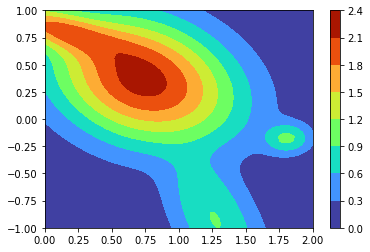

In [17]:
nx = 101
ny = 51
grid = problem.point_grid(nx, ny)
velocity_field = problem.velocity_on_grid(nx, ny)
contour_x = np.array([grid[0, k, 0] for k in range(nx)])
contour_y = np.array([grid[j, 0, 1] for j in range(ny)])
contour_z = np.array([[np.linalg.norm(velocity_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();

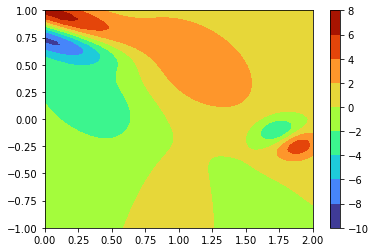

In [18]:
gradient_field = problem.velocity_gradient_on_grid(nx, ny)
#contour_z = np.array([[np.linalg.norm(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
contour_z = np.array([[sum(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();

[[[[-3.99262254e-03 -1.65611435e-03]
   [-6.93500446e-03 -2.86889783e-03]]

  [[-4.34027897e-03 -1.80296501e-03]
   [-7.65017335e-03 -3.16561181e-03]]

  [[-4.70770605e-03 -1.95966399e-03]
   [-8.42388965e-03 -3.48709455e-03]]

  ...

  [[-1.12210727e-01  1.63853041e-01]
   [-6.04796352e-02  3.92027089e-02]]

  [[-8.87010832e-02  1.33037048e-01]
   [-5.15402423e-02  3.06196357e-02]]

  [[-6.91814420e-02  1.07282207e-01]
   [-4.38790824e-02  2.35129522e-02]]]


 [[[-5.60589409e-03 -2.32500232e-03]
   [-9.58437547e-03 -3.96480971e-03]]

  [[-6.08631826e-03 -2.52778389e-03]
   [-1.05603676e-02 -4.36968342e-03]]

  [[-6.59322243e-03 -2.74371410e-03]
   [-1.16147962e-02 -4.80771482e-03]]

  ...

  [[-9.30917259e-02  1.45940727e-01]
   [-6.18730058e-02  3.24459900e-02]]

  [[-7.22728234e-02  1.18206175e-01]
   [-5.30591487e-02  2.47024395e-02]]

  [[-5.51413973e-02  9.51532322e-02]
   [-4.55043681e-02  1.83699141e-02]]]


 [[[-7.79729346e-03 -3.23350361e-03]
   [-1.31138593e-02 -5.42475484e-

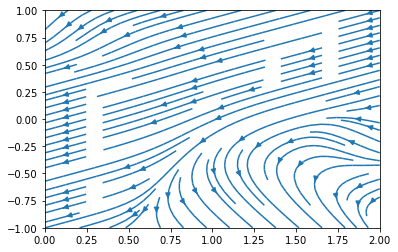

In [19]:
print(problem.velocity_gradient_matrix_on_grid(nx, ny))
plt.streamplot(contour_x, contour_y, velocity_field[:, :, 0], velocity_field[:, :, 1])